<a href="https://colab.research.google.com/github/SizhuangHe/FL-REU/blob/main/FL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%load_ext tensorboard
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import copy
import random
import time

import torch
import torch.nn as nn
import torch.nn.functional as F

import pandas as pd
import sklearn
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms, utils
from torchsummary import summary

# Check assigned GPU
# gpu_info = !nvidia-smi
# gpu_info = '\n'.join(gpu_info)
# if gpu_info.find('failed') >= 0:
#   print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
#   print('and then re-execute this cell.')
# else:
#   print(gpu_info)

# set manual seed for reproducibility
seed = 42

# general reproducibility
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# gpu training specific
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Some Hyperparameters

In [2]:
input_size = 4
num_hidden_neuron = 100
output_size = 3

# Load DataSet

## Prepare the Data

In [3]:
df = pd.read_csv("Iris.csv")

le=LabelEncoder()
df['Species']=le.fit_transform(df['Species'])

label=df['Species'].values

scaler=StandardScaler()
df = df.drop('Species',axis=1)
df = df.drop('Id', axis=1)
scaled_df=scaler.fit_transform(df)

feature=scaled_df.astype(np.float32)




In [4]:
feature_train,feature_test,label_train, label_test=train_test_split(feature, label,test_size=0.20,random_state=42)

In [5]:
class IrisData(Dataset):
  def __init__(self, feature_train, label_train):
    self.feature = feature_train
    self.label = label_train

  def __len__(self):
    return len(self.label) 

  def __getitem__(self, idx):
    return self.feature[idx], self.label[idx]   

In [6]:
dataset_train = IrisData(feature_train, label_train)
dataset_test = IrisData(feature_test, label_test)

In [7]:
classes_test = [0, 1, 2, 3] #don't know how to do here

# Partition the Data

In [8]:
def iid_partition(dataset, clients):
  """
  I.I.D paritioning of data over clients
  Shuffle the data
  Split it between clients
  
  params:
    - dataset (torch.utils.Dataset): Dataset containing the MNIST Images
    - clients (int): Number of Clients to split the data between

  returns:
    - Dictionary of image indexes for each client
  """

  num_items_per_client = int(len(dataset)/clients)
  client_dict = {}
  image_idxs = [i for i in range(len(dataset))]

  for i in range(clients):
    client_dict[i] = set(np.random.choice(image_idxs, num_items_per_client, replace=False))
    image_idxs = list(set(image_idxs) - client_dict[i])

  return client_dict

In [9]:
def non_iid_partition(dataset, clients, total_shards, shards_size, num_shards_per_client):
  """
  non I.I.D parititioning of data over clients
  Sort the data by the digit label
  Divide the data into N shards of size S
  Each of the clients will get X shards

  params:
    - dataset (torch.utils.Dataset): Dataset containing the MNIST Images
    - clients (int): Number of Clients to split the data between
    - total_shards (int): Number of shards to partition the data in
    - shards_size (int): Size of each shard 
    - num_shards_per_client (int): Number of shards of size shards_size that each client receives

  returns:
    - Dictionary of image indexes for each client
  """

  
  shard_idxs = [i for i in range(total_shards)]
  client_dict = {i: np.array([], dtype='int64') for i in range(clients)}
  idxs = np.arange(len(dataset))
  data_labels = dataset.label

  # sort the labels
  label_idxs = np.vstack((idxs, data_labels))
  label_idxs = label_idxs[:, label_idxs[1,:].argsort()]
  idxs = label_idxs[0,:]

  # divide the data into total_shards of size shards_size
  # assign num_shards_per_client to each client
  for i in range(clients):
    rand_set = set(np.random.choice(shard_idxs, num_shards_per_client, replace=False))
    shard_idxs = list(set(shard_idxs) - rand_set)

    for rand in rand_set:
      client_dict[i] = np.concatenate((client_dict[i], idxs[rand*shards_size:(rand+1)*shards_size]), axis=0)
  
  return client_dict




# Models

In [10]:
class IRIS_NN(nn.Module):
  def __init__(self, input_size, num_hidden_neurons, output_size):
    super(IRIS_NN, self).__init__()

    self.l1 = nn.Linear(input_size, num_hidden_neurons)
    self.l2 = nn.Linear(num_hidden_neurons, num_hidden_neurons)
    self.l3 = nn.Linear(num_hidden_neurons, output_size)

  def forward(self, x):
    x = torch.flatten(x,1)
    x = F.relu(self.l1(x))
    x = F.relu(self.l2(x))
    out = self.l3(x)
    return out

In [11]:
model_iid = IRIS_NN(input_size, num_hidden_neuron, output_size)
model_non_iid = IRIS_NN(input_size, num_hidden_neuron, output_size)

# Client Training


In [12]:
class CustomDataset(Dataset):
  def __init__(self, dataset, idxs):
      self.dataset = dataset
      self.idxs = list(idxs)

  def __len__(self):
      return len(self.idxs)

  def __getitem__(self, item):
      image, label = self.dataset[self.idxs[item]]
      return image, label

class ClientUpdate(object):
  def __init__(self, dataset, batchSize, learning_rate, epochs, idxs):
    self.train_loader = DataLoader(CustomDataset(dataset, idxs), batch_size=batchSize, shuffle=True)

    self.learning_rate = learning_rate
    self.epochs = epochs

  def train(self, model):

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=self.learning_rate, momentum=0.5)
    # optimizer = torch.optim.Adam(model.parameters(), lr=self.learning_rate)

    e_loss = []
    for epoch in range(1, self.epochs+1):

      train_loss = 0.0

      model.train()
      for data, labels in self.train_loader:

        if torch.cuda.is_available():
          data, labels = data.cuda(), labels.cuda()

        # clear the gradients
        optimizer.zero_grad()
        # make a forward pass
        output = model(data)
        # calculate the loss
        loss = criterion(output, labels)
        # do a backwards pass
        loss.backward()
        # perform a single optimization step
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)

      # average losses
      train_loss = train_loss/len(self.train_loader.dataset)
      e_loss.append(train_loss)

    total_loss = sum(e_loss)/len(e_loss)

    return model.state_dict(), total_loss

# Server Training

In [13]:
def training(model, rounds, batch_size, lr, ds, data_dict, C, K, E, plt_title, plt_color):
  """
  Function implements the Federated Averaging Algorithm from the FedAvg paper.
  Specifically, this function is used for the server side training and weight update

  Params:
    - model:           PyTorch model to train
    - rounds:          Number of communication rounds for the client update
    - batch_size:      Batch size for client update training
    - lr:              Learning rate used for client update training
    - ds:              Dataset used for training
    - data_dict:       Type of data partition used for training (IID or non-IID)
    - C:               Fraction of clients randomly chosen to perform computation on each round
    - K:               Total number of clients
    - E:               Number of training passes each client makes over its local dataset per round
    - tb_writer_name:  Directory name to save the tensorboard logs
  Returns:
    - model:           Trained model on the server
  """

  # global model weights
  global_weights = model.state_dict()

  # training loss
  train_loss = []
  
  # measure time
  start = time.time()

  for curr_round in range(1, rounds+1):
    w, local_loss = [], []

    m = max(int(C*K), 1)
    
    S_t = np.random.choice(range(K), m, replace=False)
    for k in S_t:
      local_update = ClientUpdate(dataset=ds, batchSize=batch_size, learning_rate=lr, epochs=E, idxs=data_dict[k])
      weights, loss = local_update.train(model=copy.deepcopy(model))

      w.append(copy.deepcopy(weights))
      local_loss.append(copy.deepcopy(loss))

    # updating the global weights
    weights_avg = copy.deepcopy(w[0])
    for k in weights_avg.keys():
      for i in range(1, len(w)):
        weights_avg[k] += w[i][k]

      weights_avg[k] = torch.div(weights_avg[k], len(w))

    global_weights = weights_avg

    # move the updated weights to our model state dict
    model.load_state_dict(global_weights)

    # loss
    loss_avg = sum(local_loss) / len(local_loss)
    print('Round: {}... \tAverage Loss: {}'.format(curr_round, round(loss_avg, 3)))
    train_loss.append(loss_avg)

  end = time.time()
  fig, ax = plt.subplots()
  x_axis = np.arange(1, rounds+1)
  y_axis = np.array(train_loss)
  ax.plot(x_axis, y_axis, 'tab:'+plt_color)

  ax.set(xlabel='Number of Rounds', ylabel='Train Loss',
       title=plt_title)
  ax.grid()
  fig.savefig(plt_title+'.jpg', format='jpg')
  print("Training Done!")
  print("Total time taken to Train: {}".format(end-start))
  
  return model

# Test

In [59]:
def testing(model, dataset, bs, criterion, num_classes, classes):
  #test loss 
  test_loss = 0.0
  correct_class = list(0. for i in range(num_classes))

  total_class = list(0. for i in range(num_classes))

  test_loader = DataLoader(dataset, batch_size=bs)
  
  model.eval()
  for data, labels in test_loader:

    if torch.cuda.is_available():
      data, labels = data.cuda(), labels.cuda()

    output = model(data)
    loss = criterion(output, labels)
    test_loss += loss.item()*data.size(0)

    _, pred = torch.max(output, 1)


    correct_tensor = pred.eq(labels.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(correct_tensor.cpu().numpy())

    print(f"labels: {labels}, pred: {pred}, correct: {correct}")

    #test accuracy for each object class
    for i in range(len(data)):
      label = labels.data[i]
      print(f"label: {label}")
      print(f"correct_class: {correct_class}")
      correct_class[label] += correct[i].item()
      total_class[label] += 1
    
  # avg test loss
  test_loss = test_loss/len(test_loader.dataset)
  print("Test Loss: {:.6f}\n".format(test_loss))

  # print test accuracy
  for i in range(num_classes):
    if total_class[i]>0:
      print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % 
            (classes[i], 100 * correct_class[i] / total_class[i],
            np.sum(correct_class[i]), np.sum(total_class[i])))
    else:
      print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

  print('\nFinal Test  Accuracy: {:.3f} ({}/{})'.format(
        100. * np.sum(correct_class) / np.sum(total_class),
        np.sum(correct_class), np.sum(total_class)))

# IID Case

## Training

In [ ]:
# number of training rounds
rounds = 100
# client fraction
C = 0.1
# number of clients
K = 3
# number of training passes on local dataset for each roung
E = 5
# batch size
batch_size = 10
# learning Rate
lr=0.01
# data partition dictionary
iid_dict = iid_partition(dataset_train, 3)

if torch.cuda.is_available():
  model.cuda()

model_iid_trained = training(model, rounds, batch_size, lr, dataset_train, iid_dict, C, K, E, "on IID Dataset", "orange")

## Testing

In [60]:
criterion = nn.CrossEntropyLoss()
testing(model_iid_trained, dataset_test, 10, criterion, 3, classes_test)

#why only 9/9?

labels: tensor([1, 0, 2, 1, 1, 0, 1, 2, 1, 1], device='cuda:0'), pred: tensor([1, 0, 2, 1, 1, 0, 1, 2, 2, 1], device='cuda:0'), correct: [ True  True  True  True  True  True  True  True False  True]
label: 1
correct_class: [0.0, 0.0, 0.0]
label: 0
correct_class: [0.0, 1.0, 0.0]
label: 2
correct_class: [1.0, 1.0, 0.0]
label: 1
correct_class: [1.0, 1.0, 1.0]
label: 1
correct_class: [1.0, 2.0, 1.0]
label: 0
correct_class: [1.0, 3.0, 1.0]
label: 1
correct_class: [2.0, 3.0, 1.0]
label: 2
correct_class: [2.0, 4.0, 1.0]
label: 1
correct_class: [2.0, 4.0, 2.0]
label: 1
correct_class: [2.0, 4.0, 2.0]
labels: tensor([2, 0, 0, 0, 0, 1, 2, 1, 1, 2], device='cuda:0'), pred: tensor([2, 0, 0, 0, 0, 1, 2, 1, 1, 2], device='cuda:0'), correct: [ True  True  True  True  True  True  True  True  True  True]
label: 2
correct_class: [2.0, 5.0, 2.0]
label: 0
correct_class: [2.0, 5.0, 3.0]
label: 0
correct_class: [3.0, 5.0, 3.0]
label: 0
correct_class: [4.0, 5.0, 3.0]
label: 0
correct_class: [5.0, 5.0, 3.0]
la

# Non IID training

Round: 1... 	Average Loss: 0.009
Round: 2... 	Average Loss: 0.08
Round: 3... 	Average Loss: 0.063
Round: 4... 	Average Loss: 0.009
Round: 5... 	Average Loss: 0.004
Round: 6... 	Average Loss: 0.083
Round: 7... 	Average Loss: 0.067
Round: 8... 	Average Loss: 0.067
Round: 9... 	Average Loss: 0.066
Round: 10... 	Average Loss: 0.012
Round: 11... 	Average Loss: 0.005
Round: 12... 	Average Loss: 0.069
Round: 13... 	Average Loss: 0.006
Round: 14... 	Average Loss: 0.055
Round: 15... 	Average Loss: 0.049
Round: 16... 	Average Loss: 0.079
Round: 17... 	Average Loss: 0.012
Round: 18... 	Average Loss: 0.073
Round: 19... 	Average Loss: 0.011
Round: 20... 	Average Loss: 0.005
Round: 21... 	Average Loss: 0.072
Round: 22... 	Average Loss: 0.01
Round: 23... 	Average Loss: 0.059
Round: 24... 	Average Loss: 0.005
Round: 25... 	Average Loss: 0.074
Round: 26... 	Average Loss: 0.066
Round: 27... 	Average Loss: 0.009
Round: 28... 	Average Loss: 0.065
Round: 29... 	Average Loss: 0.064
Round: 30... 	Average Los

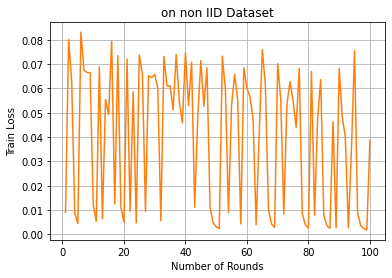

In [17]:
# number of training rounds
rounds = 100
# client fraction
C = 0.1
# number of clients
K = 3
# number of training passes on local dataset for each roung
E = 5
# batch size
batch_size = 10
# learning Rate
lr=0.01
# data partition dictionary
iid_dict = non_iid_partition(dataset_train, 3, 12, 10, 4)

if torch.cuda.is_available():
  model.cuda()

model_non_iid_trained = training(model_non_iid, rounds, batch_size, lr, dataset_train, iid_dict, C, K, E, "on non IID Dataset", "orange")

## Test

In [18]:
criterion = nn.CrossEntropyLoss()
testing(model_non_iid_trained, dataset_test, 10, criterion, 3, classes_test)

pred: tensor([1, 0, 2, 1, 1, 0, 1, 2, 2, 1], device='cuda:0')
pred: tensor([2, 0, 0, 0, 0, 1, 2, 1, 1, 2], device='cuda:0')
pred: tensor([0, 2, 0, 2, 2, 2, 2, 2, 0, 0], device='cuda:0')
Test Loss: 0.045615

Test Accuracy of     0: 100% ( 5/ 5)
Test Accuracy of     1: 100% ( 1/ 1)
Test Accuracy of     2: 100% ( 3/ 3)

Final Test  Accuracy: 100.000 (9.0/9.0)
